# Spectral Clustering


This Code template is for the Cluster analysis using a Spectral Clustering algorithm and includes 2D and 3D cluster visualization of the Clusters.

### Required Packages

In [ ]:
!pip install plotly

In [2]:
import operator
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import plotly.graph_objects as go
from sklearn.cluster import SpectralClustering
from scipy.spatial.distance import pdist, squareform
import scipy
from scipy.sparse import csgraph
from numpy import linalg as LA
warnings.filterwarnings("ignore")

### Initialization

Filepath of CSV file

In [53]:
#filepath
file_path= ""

List of features which are  required for model training .

In [56]:
#x_values
features=[]

### Data Fetching

Pandas is an open-source, BSD-licensed library providing high-performance, easy-to-use data manipulation and data analysis tools.

We will use panda's library to read the CSV file using its storage path.And we use the head function to display the initial row or entry.

In [54]:
df=pd.read_csv(file_path)
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


### Feature Selections

It is the process of reducing the number of input variables when developing a predictive model. Used to reduce the number of input variables to both reduce the computational cost of modelling and, in some cases, to improve the performance of the model.

We will assign all the required input features to X 

In [57]:
X=df[features]

### Data Preprocessing

Since the majority of the machine learning models in the Sklearn library doesn't handle string category data and Null value, we have to explicitly remove or replace null values. The below snippet have functions, which removes the null value if any exists. And convert the string classes data in the datasets by encoding them to integer classes.


In [58]:
def NullClearner(df):
    if(isinstance(df, pd.Series) and (df.dtype in ["float64","int64"])):
        df.fillna(df.mean(),inplace=True)
        return df
    elif(isinstance(df, pd.Series)):
        df.fillna(df.mode()[0],inplace=True)
        return df
    else:return df
def EncodeX(df):
    return pd.get_dummies(df)

Calling preprocessing functions on the feature and target set.


In [59]:
x=X.columns.to_list()
for i in x:
    X[i]=NullClearner(X[i])
X=EncodeX(X)
X.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


 #### How to select optimal number of cluster in Spectral Clustering:-<br/>
   In spectral clustering, one way to identify the number of clusters is to plot the eigenvalue spectrum. If the clusters are clearly defined, there should be a “gap” in the smallest eigenvalues at the “optimal” k. This is called eigengap heuristic.
<br/><br/>
Eigengap heuristic suggests the number of clusters k is usually given by the value of k that maximizes the eigengap (difference between consecutive eigenvalues). The larger this eigengap is, the closer the eigenvectors of the ideal case and hence the better spectral clustering works.



This method performs the eigen decomposition on a affinity matrix. Steps are:-
<br/><br/>
    1. Construct the normalized affinity matrix: L = D−1/2ADˆ −1/2.<br/>
    2. Find the eigenvalues and their associated eigen vectors<br/>
    3. Identify the maximum gap which corresponds to the number of clusters by eigengap heuristic

#### Affinity matrix

Calculate affinity matrix based on input coordinates matrix and the number of nearest neighbours.



In [60]:
def getAffinityMatrix(coordinates, k = 7):
    dists = squareform(pdist(coordinates)) 
    knn_distances = np.sort(dists, axis=0)[k]
    knn_distances = knn_distances[np.newaxis].T
    local_scale = knn_distances.dot(knn_distances.T)
    affinity_matrix = -pow(dists,2)/ local_scale
    affinity_matrix[np.where(np.isnan(affinity_matrix))] = 0.0
    affinity_matrix = np.exp(affinity_matrix)
    np.fill_diagonal(affinity_matrix, 0)
    return affinity_matrix

In [80]:

def eigenDecomposition(A, plot = True, topK = 10): #A: Affinity matrix
    L = csgraph.laplacian(A, normed=True)
    n_components = A.shape[0]
    eigenvalues, eigenvectors = LA.eig(L)   
    if plot:
        plt.figure(1,figsize=(20,8))
        plt.title('Largest eigen values of input matrix')
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.grid()
    index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:topK]
    nb_clusters = index_largest_gap + 1        
    return nb_clusters

Top 10 Optimal number of clusters [ 2  3  5  6  9 11 28 41 48 54]


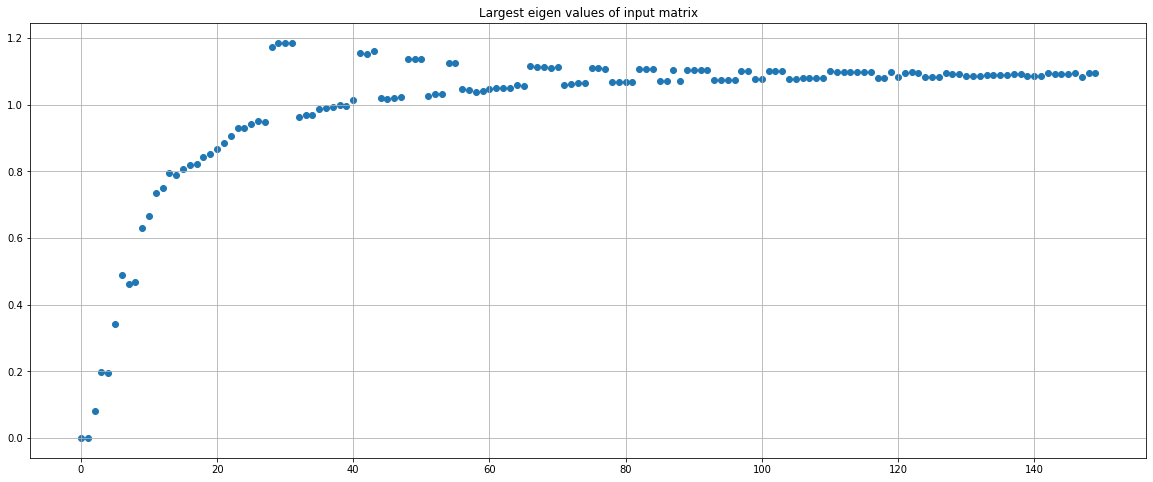

In [91]:
affinity_matrix = getAffinityMatrix(X, k = 10)
k = eigenDecomposition(affinity_matrix)
k.sort()
print(f'Top 10 Optimal number of clusters {k}')

### Model

Spectral Clustering is very useful when the structure of the individual clusters is highly non-convex, or more generally when a measure of the center and spread of the cluster is not a suitable description of the complete cluster, such as when clusters are nested circles on the 2D plane.
#### Model Tuning Parameters
   > - n_clusters -> The dimension of the projection subspace.

   > - eigen_solver -> The eigenvalue decomposition strategy to use. AMG requires pyamg to be installed. It can be faster on very large, sparse problems, but may also lead to instabilities. If None, then 'arpack' is used.
   
   > - n_components -> Number of eigenvectors to use for the spectral embedding.

   > - gamma -> Kernel coefficient for rbf, poly, sigmoid, laplacian and chi2 kernels. Ignored for affinity='nearest_neighbors'.

[More information](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html)

In [84]:
model = SpectralClustering(n_clusters=5, affinity='nearest_neighbors' ,random_state=101)

In [85]:
ClusterDF = X.copy()
ClusterDF['ClusterID'] = model.fit_predict(X)
ClusterDF.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,ClusterID
0,5.1,3.5,1.4,0.2,3
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,3


### Cluster Records

The below bar graphs show the number of data points in each available cluster.

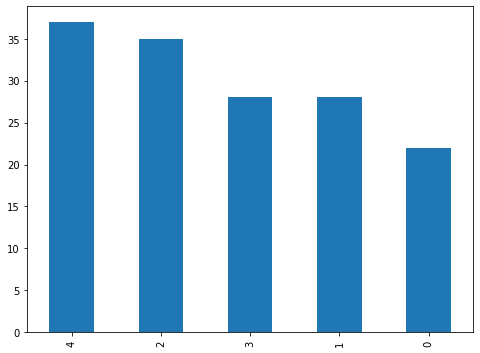

In [86]:
ClusterDF['ClusterID'].value_counts().plot(kind='bar')

### Cluster Plots

Below written functions get utilized to plot 2-Dimensional and 3-Dimensional cluster plots on the available set of features in the dataset. Plots include different available clusters along with cluster centroid.

In [87]:
def Plot2DCluster(X_Cols,df):
    for i in list(itertools.combinations(X_Cols, 2)):
        plt.rcParams["figure.figsize"] = (8,6)
        xi,yi=df.columns.get_loc(i[0]),df.columns.get_loc(i[1])
        for j in df['ClusterID'].unique():
            DFC=df[df.ClusterID==j]
            plt.scatter(DFC[i[0]],DFC[i[1]],cmap=plt.cm.Accent,label=j)
        plt.xlabel(i[0])
        plt.ylabel(i[1])
        plt.legend()
        plt.show()

def Plot3DCluster(X_Cols,df):
    for i in list(itertools.combinations(X_Cols, 3)):
        xi,yi,zi=df.columns.get_loc(i[0]),df.columns.get_loc(i[1]),df.columns.get_loc(i[2])
        fig,ax = plt.figure(figsize = (16, 10)),plt.axes(projection ="3d")
        ax.grid(b = True, color ='grey',linestyle ='-.',linewidth = 0.3,alpha = 0.2)
        for j in df['ClusterID'].unique():
            DFC=df[df.ClusterID==j]
            ax.scatter3D(DFC[i[0]],DFC[i[1]],DFC[i[2]],alpha = 0.8,cmap=plt.cm.Accent,label=j)
        ax.set_xlabel(i[0])
        ax.set_ylabel(i[1])
        ax.set_zlabel(i[2])
        plt.legend()
        plt.show()
    
def Plotly3D(X_Cols,df):
    for i in list(itertools.combinations(X_Cols,3)):
        xi,yi,zi=df.columns.get_loc(i[0]),df.columns.get_loc(i[1]),df.columns.get_loc(i[2])
        fig2=px.scatter_3d(df, x=i[0], y=i[1],z=i[2],color=df['ClusterID'])
        fig2.show()

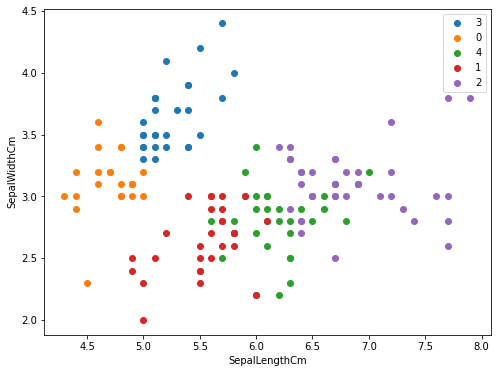

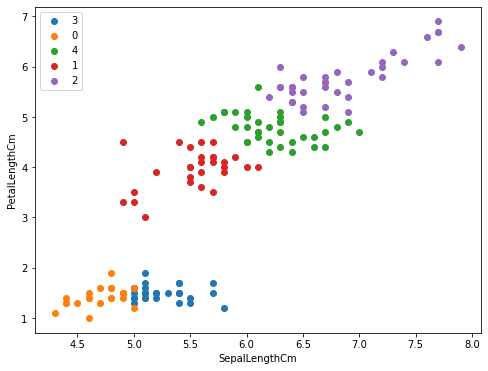

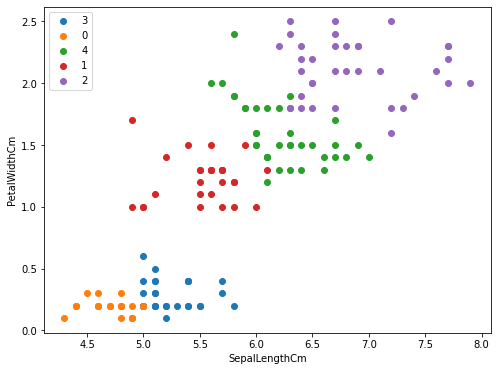

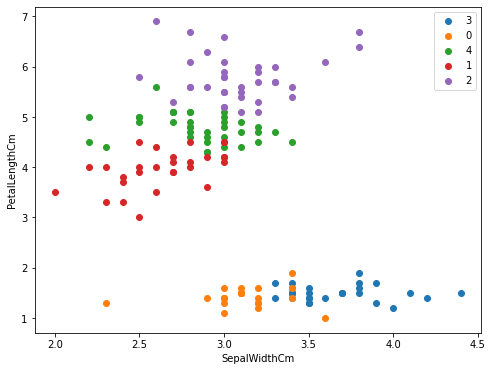

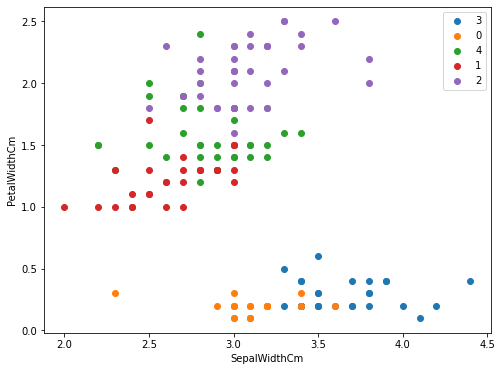

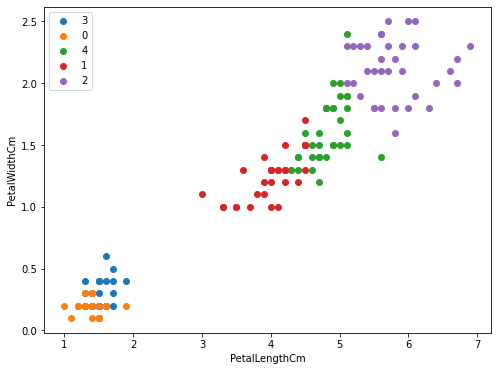

In [88]:
Plot2DCluster(X.columns,ClusterDF)

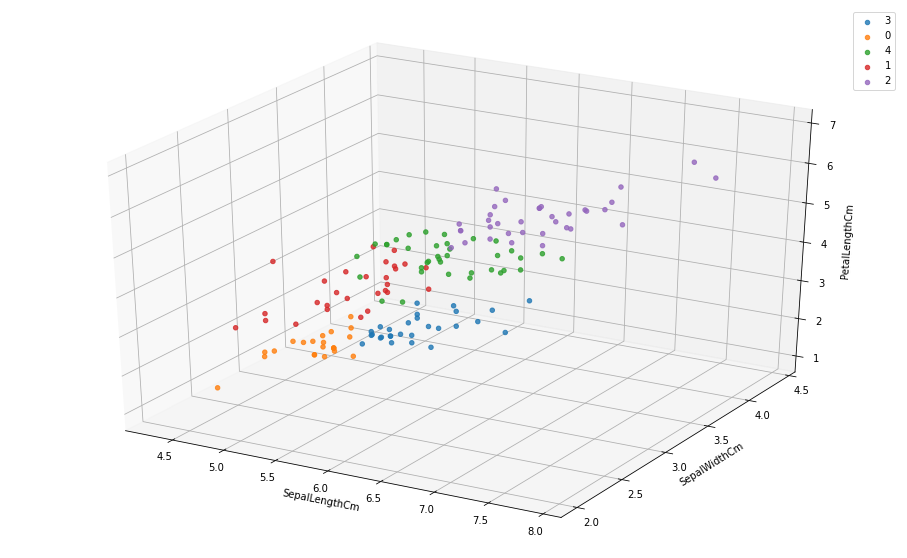

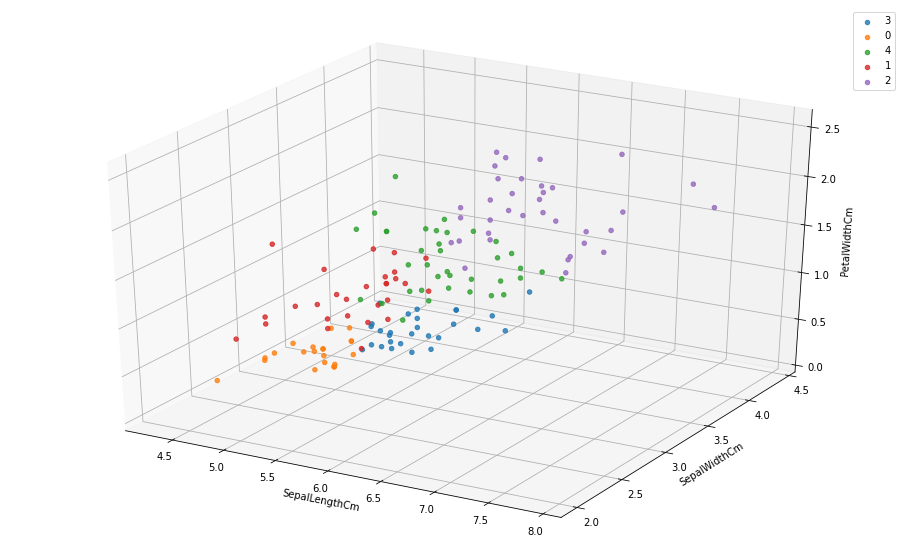

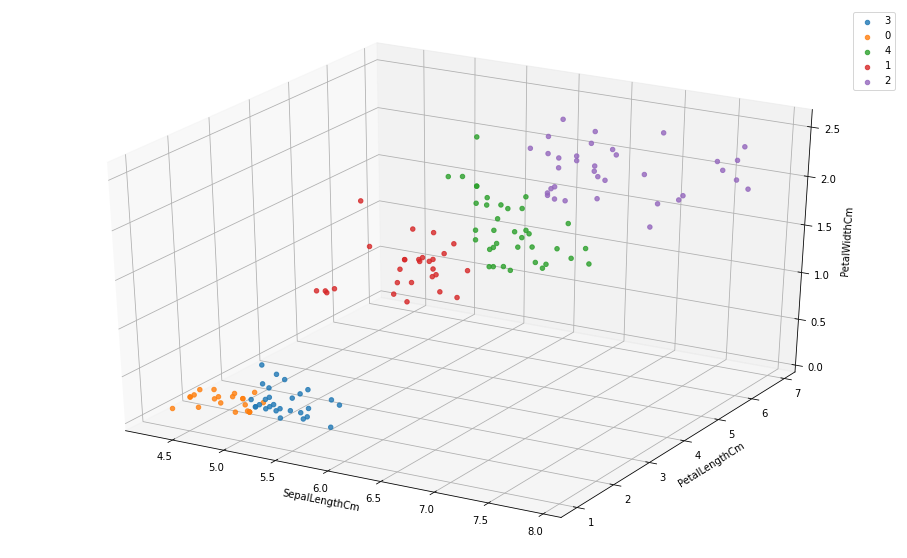

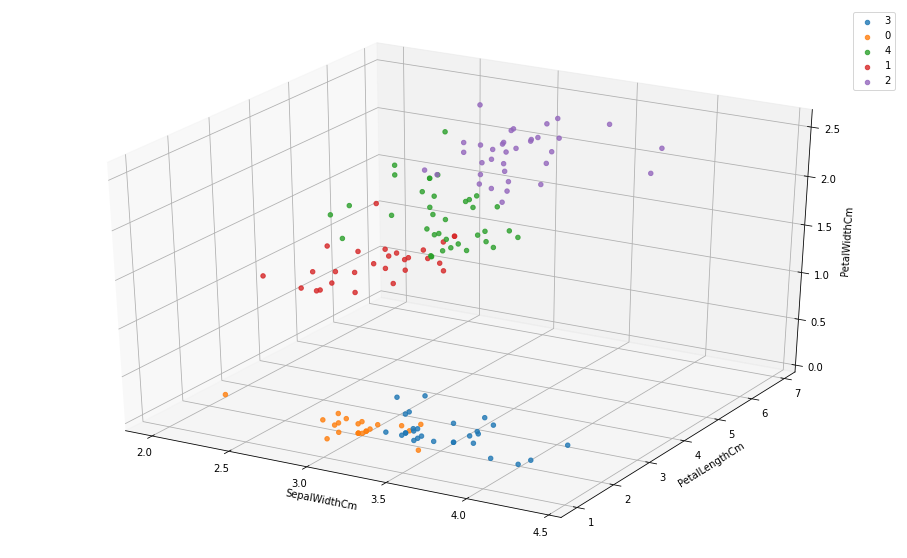

In [93]:
Plot3DCluster(X.columns,ClusterDF)

In [92]:
Plotly3D(X.columns,ClusterDF)

#### Creator: Arpit Somani , Github: [Profile](https://github.com/arpitsomani8)
